In [1]:
# ignoring the warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from textwrap import wrap
from wordcloud import WordCloud
from nltk import FreqDist

# Removing Stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize

# Lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
#Reading Data

In [62]:
from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_csv('/content/gdrive/MyDrive/data.csv',encoding='unicode_escape')
data.head()


Mounted at /content/gdrive


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [63]:
data.shape

(541909, 8)

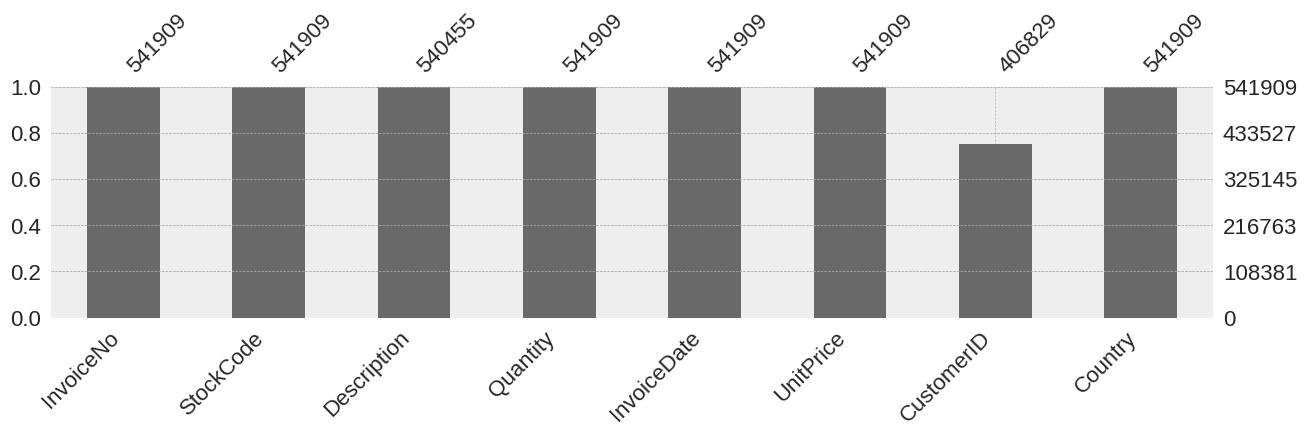

In [64]:
#Understanding and Preparing Data
#Handling Missing Values


# Visulaising missing value
plt.style.use('bmh')
msno.bar(data,figsize = (15,3))
plt.show()

In [65]:
# Dropping missing value in CustomerID and Description
data = data.dropna(subset =['Description','CustomerID'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [66]:
#Handling Duplicates

# checking for duplicates
data.duplicated().sum()


5225

In [67]:

# dropping duplicates
data = data.drop_duplicates()
data.duplicated().sum()

0

In [68]:
# Filter only numeric columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Calculate outliers for each numeric column
outliers = {}
for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    outliers[col] = ((data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))).sum()

# Print results
for col, count in outliers.items():
    print(f"Column '{col}' has {count} outliers")

Column 'Quantity' has 26646 outliers
Column 'UnitPrice' has 35802 outliers
Column 'CustomerID' has 0 outliers


In [69]:
for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    outlier_mask = (data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))
    outlier_values = data[col][outlier_mask]

    print(f"\nOutliers in '{col}':")
    print(outlier_values)


Outliers in 'Quantity':
9         32
31        48
44        36
46        80
65        32
          ..
541835    40
541865    40
541866    36
541867    72
541868    48
Name: Quantity, Length: 26646, dtype: int64

Outliers in 'UnitPrice':
5          7.65
16         9.95
19         7.95
20         7.95
45        18.00
          ...  
541768    18.00
541786    11.95
541831     8.50
541849     9.95
541892     8.95
Name: UnitPrice, Length: 35802, dtype: float64

Outliers in 'CustomerID':
Series([], Name: CustomerID, dtype: float64)


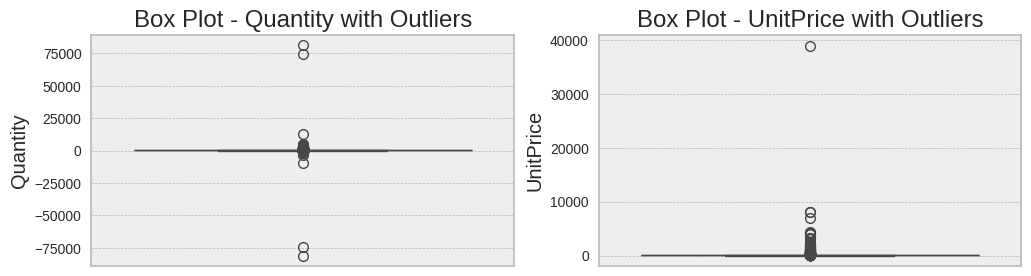

In [70]:

# Visualization of outliers in 'Quantity' & 'UnitPrice' column
plt.style.use('bmh')
plt.figure(figsize=(12,3))
plt.subplot(121)
sns.boxplot(data['Quantity'])
plt.title('Box Plot - Quantity with Outliers')
plt.subplot(122)
sns.boxplot(data['UnitPrice'])
plt.title('Box Plot - UnitPrice with Outliers')
plt.show()

In [71]:
# creating dataframe to view details of extreme negative outliers in 'Quantity' column
df_Quantity_negative = data[data.Quantity <= -60000.0].groupby(['CustomerID','Description'])
df_Quantity_negative.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,12/9/2011 9:27,2.08,16446.0,United Kingdom


In [72]:

# creating dataframe to view details of extreme positive outliers in 'Quantity' column
df_Quantity_positive = data[data.Quantity >= 60000.0].groupby(['CustomerID','Description'])
df_Quantity_positive.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom


In [73]:

# clipping outliers in Quantity & UnitPrice
q3 = data.UnitPrice.quantile(0.75)
q1 = data.UnitPrice.quantile(0.25)
iqr = q3 - q1
#thresholds
upper = q3 + (1.5 * iqr)
lower = q1 - (1.5 * iqr)
print(upper)
print(lower)

7.5
-2.5


In [74]:

data.Quantity = data.Quantity.clip(-13,27)
data.UnitPrice = data.UnitPrice.clip(-2.5,7.5)

In [75]:
#Data preprocessing and EDA
data.Description.value_counts()

,count
Description,
WHITE HANGING HEART T-LIGHT HOLDER,2058
REGENCY CAKESTAND 3 TIER,1894
JUMBO BAG RED RETROSPOT,1659
PARTY BUNTING,1409
ASSORTED COLOUR BIRD ORNAMENT,1405
...,...
PINK/WHITE GLASS DEMI CHOKER,1
I LOVE LONDON MINI RUCKSACK,1
SET 36 COLOURING PENCILS DOILEY,1


In [76]:
# Filter rows where the value in the column is a string (object type)
filtered_rows = data[data['StockCode'].apply(lambda x: isinstance(x, str) and x.isalpha())]
print(filtered_rows['StockCode'].unique())


['POST' 'D' 'M' 'PADS' 'DOT' 'CRUK']


In [77]:
data[data['StockCode'].str.contains('POST')].shape

(1196, 8)

In [78]:
data[data['StockCode'].str.contains('D')].shape

(2412, 8)

In [79]:
data[data['StockCode'].str.contains('M')].shape

(762, 8)

In [80]:
data[data['StockCode'].str.contains('PADS')].shape

(4, 8)

In [81]:
data[data['StockCode'].str.contains('DOT')].shape

(16, 8)

In [82]:
data[data['StockCode'].str.contains('CRUK')].shape

(16, 8)

In [83]:
#We can infer that 'Description' columnn has categories other than product description such as Discount, Manual, Postage and commission and hence will remove this categories from 'Description' column
remove_category = ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
data=data[~data['StockCode'].isin(remove_category)]
data.shape


(399835, 8)

In [94]:
# Creating new column 'Sales'
data['Sales'] = data['Quantity'] * data['UnitPrice']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


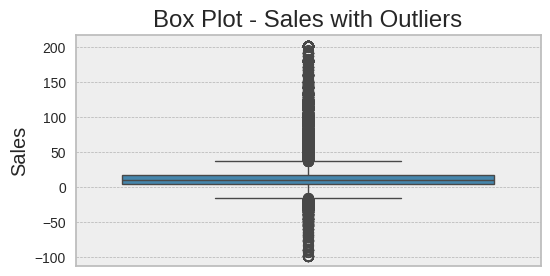

In [95]:
# Visualization of outliers in 'Sales' column
plt.style.use('bmh')
plt.figure(figsize=(6,3))
sns.boxplot(data['Sales'])
plt.title('Box Plot - Sales with Outliers');

In [96]:
# clipping outliers in Sales
data.Sales = data.Sales.clip(-15.925,37.875)

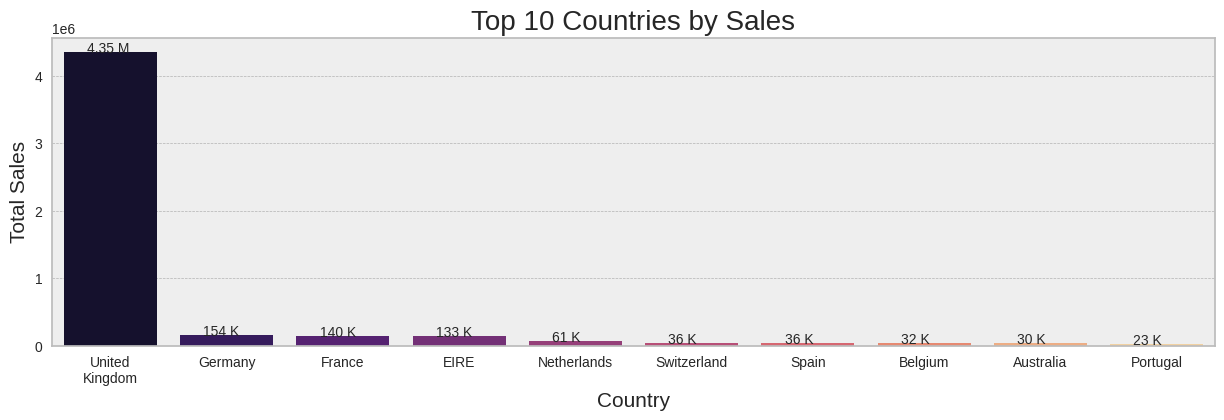

In [97]:
# Visualising Top 10 Countries by Sales
country_order = data.groupby('Country').sum()['Sales'].nlargest(10)
plt.figure(figsize = (15,4))
ax = sns.barplot(x = country_order.index, y = country_order.values, palette = 'magma')
ax.set_xlabel('Country', fontsize = 15)
ax.set_ylabel('Total Sales', fontsize = 15)
ax.set_title('Top 10 Countries by Sales', fontsize = 20)

labels = [ '\n'.join(wrap(l, 12)) for l in country_order.index ]
ax.set_xticklabels(labels, fontsize = 10)

value_labels = []
for x in country_order.values:
    value_labels.append(str(int(x/1000))+' K')
value_labels[0] = '4.35 M'

for p, label in zip(ax.patches, value_labels):
    ax.annotate(label, (p.get_x() + 0.20, p.get_height() + 2), fontsize = 10)

We can infer that total sales E commerce website in United Kingdom is 4.35 Million and while comparing other countries sales seems to be negligable.

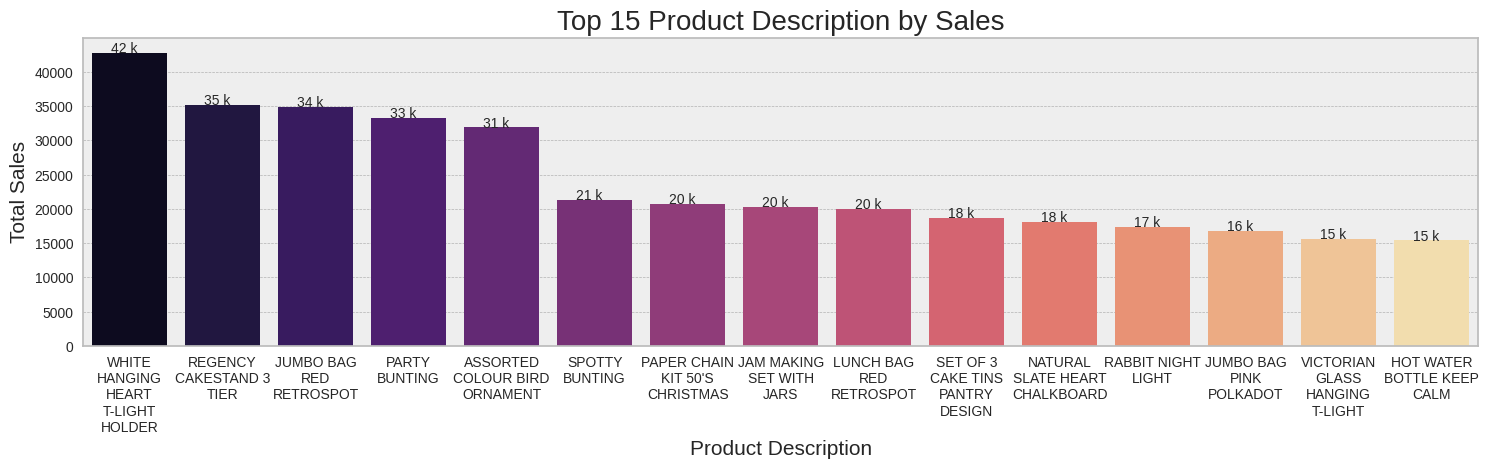

In [98]:
# Visulaising top 15 product Description by Sales
product_order = data.groupby('Description').sum()['Sales'].nlargest(15)

plt.figure(figsize = (18,4))
ax = sns.barplot(x = product_order.index, y = product_order.values, palette = 'magma')
ax.set_xlabel('Product Description', fontsize = 15)
ax.set_ylabel('Total Sales', fontsize = 15)
ax.set_title('Top 15 Product Description by Sales', fontsize = 20)

labels = [ '\n'.join(wrap(l, 12)) for l in product_order.index ]
ax.set_xticklabels(labels, fontsize = 10)

value_labels = []
for x in product_order.values:
    value_labels.append(str(int(x/1000))+' k')

for p, label in zip(ax.patches, value_labels):
    ax.annotate(label, (p.get_x() + 0.20, p.get_height() + 2), fontsize = 10)


In [99]:
# checking for duplicates
data.duplicated().sum()


21

In [100]:

# dropping duplicates
data = data.drop_duplicates()
data.duplicated().sum()

0

In [104]:
#Text Data preprocessing
# Replacing punctuations with space
data['Description_processed'] = data['Description'].str.replace("[^a-zA-Z]"," ")
# Removing digits
data['Description_processed'] = data['Description_processed'].str.replace("[0-9]"," ")
# making entire text to lowercase
data['Description_processed'] = [str(description).lower() for description in data['Description_processed']]
# repalcing short words
data['Description_processed'] = data['Description_processed'].apply(lambda row: ' '.join([word for word in row.split() if len(word)>2]))

# Removing stopwords
stop_words = stopwords.words('english')
import nltk
nltk.download('punkt_tab')

# Making custom list of words to be removed
add_words = ['small','pink','red','green','blue','white','black','large','set','purple','grey','ivory','yellow','mini']
stop_words.extend(add_words)
def remove_stopwords(des):
    description_tokenized = word_tokenize(des)
    rev_new = " ".join([i for i in description_tokenized  if i not in stop_words])
    return rev_new

data['Description_processed'] = [remove_stopwords(r) for r in data['Description_processed']]

# Lemmatization
lemmatizer = WordNetLemmatizer()
# Finds the part of speech tag and convert the detailed POS tag into a shallow information
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
nltk.download('averaged_perceptron_tagger_eng')
# lemmatize sentence using pos tag
def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

data['Description_processed']  = data['Description_processed'].apply(lambda x: lemmatize_sentence(x))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [105]:
# unique values in 'Description_processed'
data['Description_processed'].nunique()

3415

In [106]:
data.duplicated().sum()
# dropping duplicates in 'Descsription_processed'
df = data['Description_processed'].drop_duplicates()
df = pd.DataFrame(df)

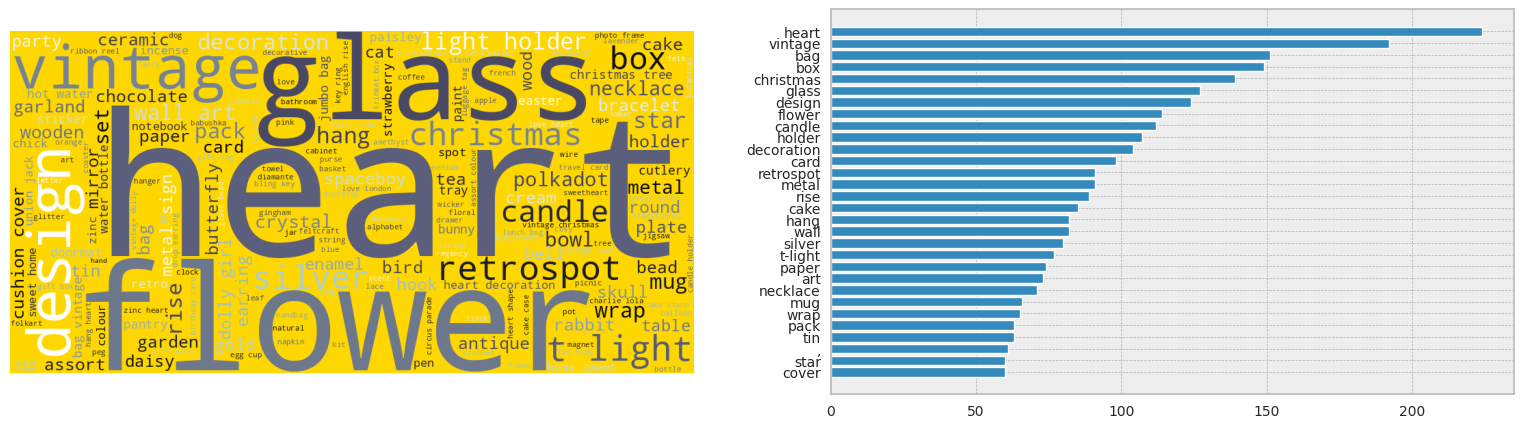

In [107]:
#Visualizing frequent word using wordcloud
# Visualizing most frequent words in 'Description'

plt.figure(1,figsize=(30,5))
plt.subplot(131)
# Plotting Frequent word using wordcloud

all_words = ' '.join([text for text in df['Description_processed']])
wordcloud = WordCloud(width = 1000, height = 500, background_color ='gold', min_font_size = 10,colormap = 'bone').generate(all_words)
plt.imshow(wordcloud)
plt.axis("off")

plt.subplot(132)
# Plotting most frequent words using bar chart
sns.set(style = 'dark')
#Extracts words into list and count frequency
all_words = all_words.split()
words_df = FreqDist(all_words)
# Extracting words and frequency from words_df object
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})
# Subsets top 30 words by frequency
words_df = words_df.nlargest(columns="count", n = 30)
words_df.sort_values('count', inplace = True)
# Plotting 30 frequent words
# plt.figure(figsize=(20,5))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()

Text Feature Extraction - Using Tf–idf term weighting

In [109]:
tfidf = TfidfVectorizer(max_features=8000,ngram_range=(2,2))
vectors = tfidf.fit_transform(df.Description_processed).toarray()
featureNames = tfidf.get_feature_names_out()
X_tfidf = pd.DataFrame(vectors,columns=featureNames)
print("n_samples: %d, n_features: %d" % X_tfidf.shape)
X_tfidf.head()

n_samples: 3415, n_features: 5517


,10 polkadot,12 chick,12 folkart,12 funky,12 rabbit,12 taper,12 vanilla,12 xmas,125g swirly,15 silver,...,zinc metal,zinc plant,zinc planter,zinc star,zinc sweetheart,zinc top,zinc tree,zinc watering,zinc willie,zinc wire
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Performing dimensionality reduction using LSA (Latent semantic analysis)

In [110]:
lsa = make_pipeline(TruncatedSVD(n_components=100,random_state=10), Normalizer(copy=False))

X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")
print("n_samples: %d, n_features: %d" % X_lsa.shape)

Explained variance of the SVD step: 13.7%
n_samples: 3415, n_features: 100


Finding optimal K value for text data clusters

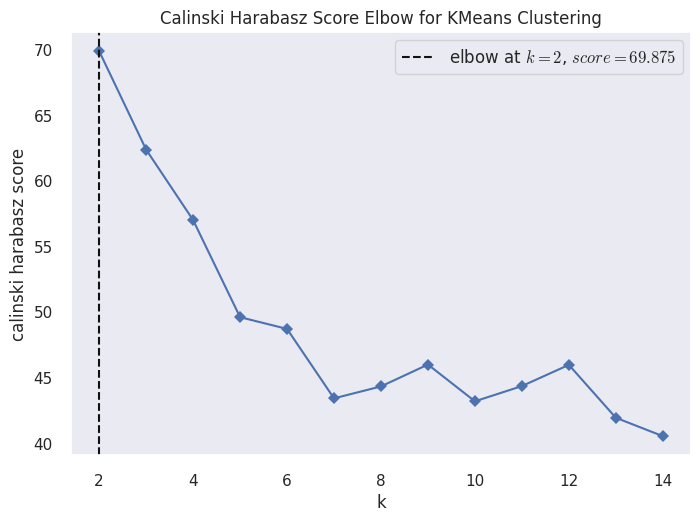

In [111]:

# Finding optimal clusters 'K value' using  Calinski-Harabasz Index
km = KMeans(random_state=10,init='k-means++',n_init=1,max_iter=100)
visualizer = KElbowVisualizer(km, k=(2,15),metric='calinski_harabasz', timings=False)
visualizer.fit(X_lsa)        # Fit the data to the visualizer
visualizer.show() ;  # Finalize and render the figure

In [112]:
#Applying KMeans clustering to Text Data
# Applying K means clusters
km = KMeans(n_clusters = 2,init='k-means++',random_state=10,n_init=1,max_iter=100)
km.fit(X_lsa)
# knowing centroids
centroids = km.cluster_centers_
# knowing each datapoints which cluter is assigned
cluster = km.labels_
# looking at the value count of points in each of the above-formed clusters:
frame = pd.DataFrame(X_lsa)
frame['Product cluster'] = cluster
frame['Product cluster'].value_counts()
# sns.countplot(frame["Product cluster"]);

,count
Product cluster,
0,1929
1,1486


In [113]:
# Top terms per cluster
original_space_centroids = lsa[0].inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = tfidf.get_feature_names_out()

for i in range(2):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()


Cluster 0: light holder wall art cushion cover play card vintage doiley glass light paisley park greet card christmas tree dolly girl 
Cluster 1: new baroque tile hook metal sign coffee mug drawer knob keep calm wall clock vintage paisley hang decoration dinner candle 


In [114]:
#Creating Product Categories using text data of 'Description'

# Reseting index
df = df.reset_index(drop=True)
# Creating DataFrame for cluster labels
df1 = pd.DataFrame(km.labels_)
# joining Dataframe
df2= df.join(df1)
df2.rename(columns={0:'Product_Category'},inplace=True)
# Merging Dataframe
df_new = pd.merge(data, df2, how='left', on='Description_processed')
print(df_new.shape)
df_new.head()

(399814, 11)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Description_processed,Product_Category
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30,hang heart t-light holder,0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,metal lantern,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00,cream cupid heart coat hanger,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,knit union flag hot water bottle,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,woolly hottie heart .,0


In [115]:
# Filtering only data of United Kingdom as majority of sales is contributed by United Kingdom
df_new = df_new[(df_new.Country == "United Kingdom")]
print(df_new.shape)
df_new.head()

(356131, 11)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Description_processed,Product_Category
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30,hang heart t-light holder,0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,metal lantern,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00,cream cupid heart coat hanger,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,knit union flag hot water bottle,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,woolly hottie heart .,0


In [116]:
# Knowing counts of unique rows in Product Category
df_new['Product_Category'].value_counts()


,count
Product_Category,
0,183710
1,172421


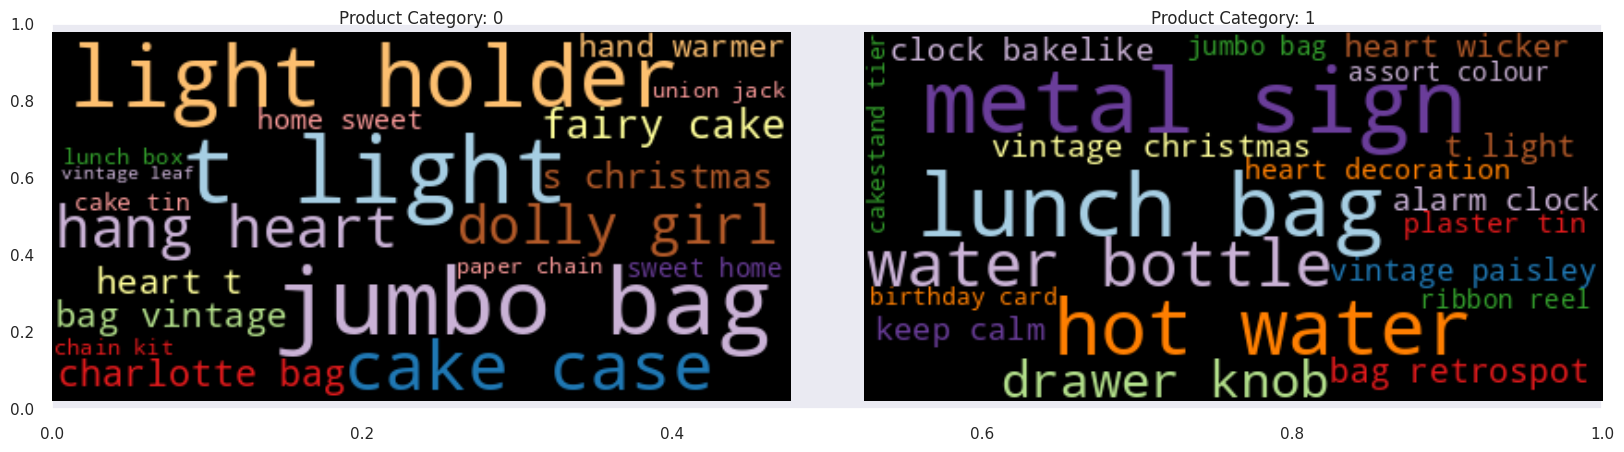

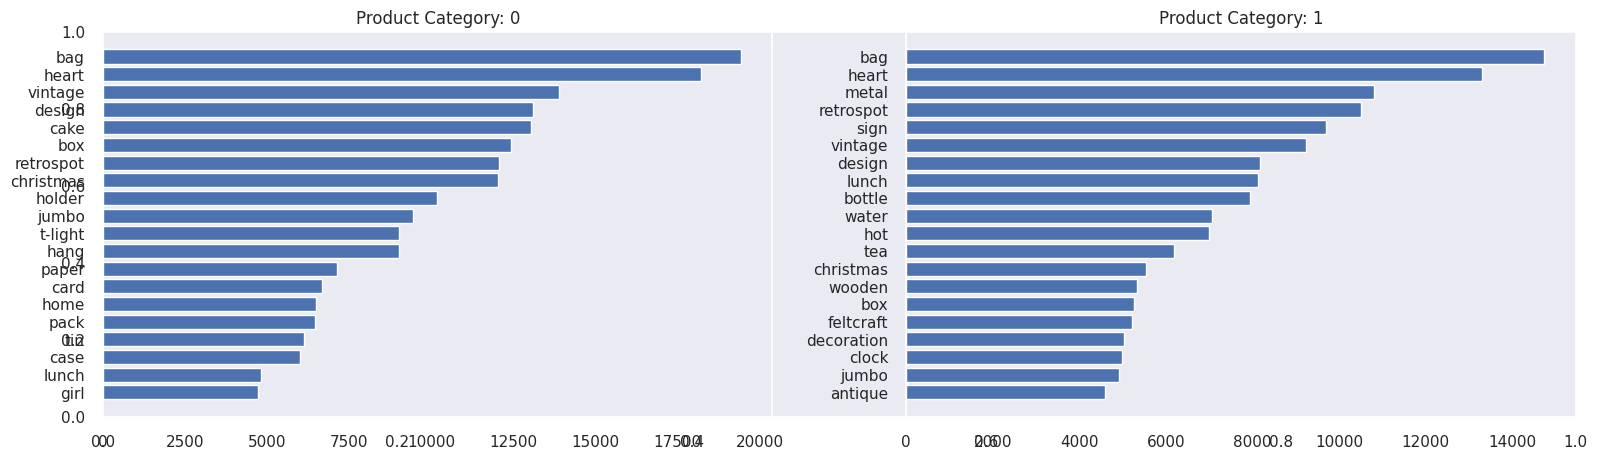

In [117]:
# Visualising frequent words in Product Categories

# create wordclouds for each Product cluster
plt.subplots(figsize=(20,5))
count=1
for k in range(0,2):
    plt.subplot(1,2,count)
    s=df_new[df_new.Product_Category==k]
    all_words = ' '.join([text for text in s['Description_processed']])
    wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="black",colormap = 'Paired_r').generate(all_words)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title('Product Category: {}'.format(k))
    plt.subplots_adjust(wspace=0.1, hspace=0.0)
    count+=1
plt.show()

# Plotting most frequent words in each Product cluster using bar chart
plt.subplots(figsize=(19,5))
sns.set(style = 'dark')
count=1
for k in range(0,2):
  plt.subplot(1,2,count)
  s=df_new[df_new.Product_Category==k]
  all_words = ' '.join([text for text in s['Description_processed']])
  all_words = all_words.split()
  words_df = FreqDist(all_words)
  # Extracting words and frequency from words_df object
  words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})
  # Subsets top 20 words by frequency
  words_df = words_df.nlargest(columns="count", n = 20)
  words_df.sort_values('count', inplace = True)
  ax = plt.barh(words_df['word'], width = words_df['count'])
  plt.title('Product Category: {}'.format(k))
  plt.axis("auto")
  count+=1
plt.show()

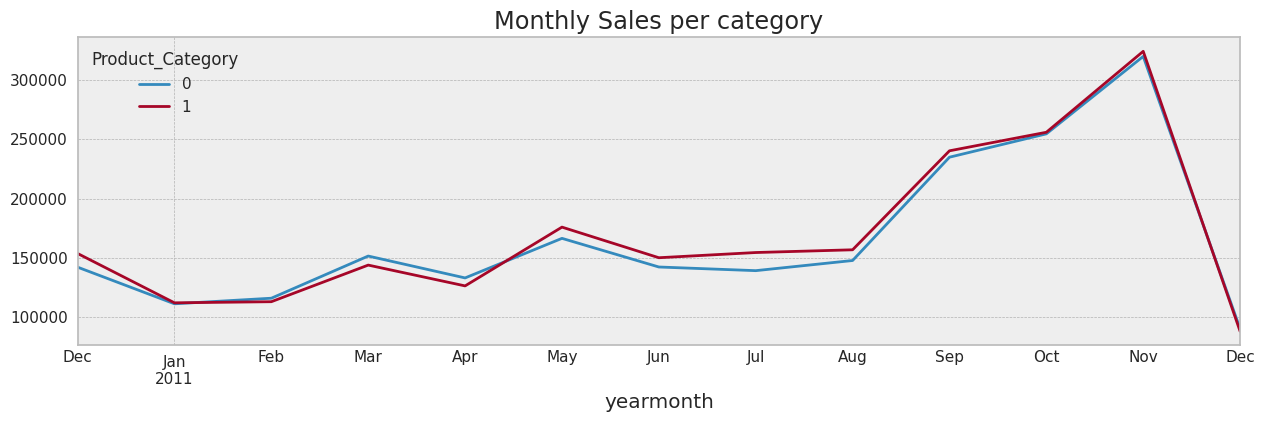

In [118]:
#Visulaising monthly wise sales of each Product category

# Visulaising monthly wise sales of each Product category
plt.style.use('bmh')
categories_per_date=df_new.copy()
df_new['InvoiceDate'] = pd.to_datetime(df_new['InvoiceDate'])
categories_per_date['yearmonth']= df_new['InvoiceDate'].dt.to_period('M')
categories_per_date=categories_per_date.pivot_table(index=['yearmonth'],
                    columns='Product_Category',
                    values='Sales',
                   # margins=True,  # add margins
                    aggfunc='sum').reset_index()
#categories_per_date.head()
lines=categories_per_date.plot.line(x="yearmonth", y=[0,1],figsize=(15,4),title='Monthly Sales per category')
plt.show()


Creating Customer Clusters based on Product Categories purchased

In [119]:
final = df_new.copy()
df3 = df_new.drop(["InvoiceNo","StockCode","Description","InvoiceDate","Description_processed","Quantity","UnitPrice","Country","Sales"],axis=1)
df4 = pd.get_dummies(df3,columns=["Product_Category"])
print(df4.shape)
df4.head()

(356131, 3)


,CustomerID,Product_Category_0,Product_Category_1
0,17850.0,True,False
1,17850.0,True,False
2,17850.0,False,True
3,17850.0,False,True
4,17850.0,True,False


In [121]:
df5 = df4.groupby('CustomerID')[['Product_Category_0','Product_Category_1']].sum()
df5.reset_index(inplace=True, level = ['CustomerID'])
df5.head()

,CustomerID,Product_Category_0,Product_Category_1
0,12346.0,0,2
1,12747.0,48,55
2,12748.0,2406,2032
3,12749.0,112,119
4,12820.0,38,21


In [122]:
dataset = df5.drop(["CustomerID"],axis=1)
dataset

,Product_Category_0,Product_Category_1
0,0,2
1,48,55
2,2406,2032
3,112,119
4,38,21
...,...,...
3938,5,5
3939,4,3
3940,8,5
3941,428,291


In [123]:
# Checking outliers in dataset
Q1 = dataset.quantile(0.25)
Q3 = dataset.quantile(0.75)
IQR = Q3 - Q1
((dataset < (Q1 - 1.5 * IQR)) | (dataset > (Q3 + 1.5 * IQR))).sum()

,0
Product_Category_0,347
Product_Category_1,347


In [124]:
# Clipping outliers in dataset
dataset['Product_Category_0']= dataset['Product_Category_0'].clip(-58.5,121.5)
dataset['Product_Category_1'] = dataset['Product_Category_1'].clip(-50.0,102.0)

In [125]:
# Finding optimal K value for cluster
# Scaling the data
scaler = StandardScaler()
X_std = scaler.fit_transform(dataset)
X_std

array([[-0.97240218, -0.9514276 ],
       [ 0.34185995,  0.69568902],
       [ 2.35432385,  2.15633961],
       ...,
       [-0.7533585 , -0.85819459],
       [ 2.35432385,  2.15633961],
       [ 0.31447949, -0.29879649]])

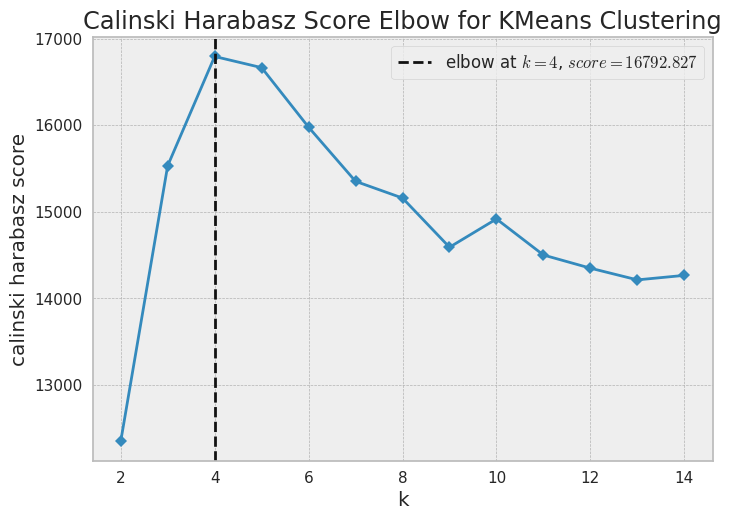

In [126]:
# Finding optimal K value using  Calinski-Harabasz Index
km = KMeans(init='k-means++',random_state=10,n_init=1,max_iter=100)
visualizer = KElbowVisualizer(km, k=(2,15),metric='calinski_harabasz', timings=False)
visualizer.fit(X_std)
visualizer.show() ;

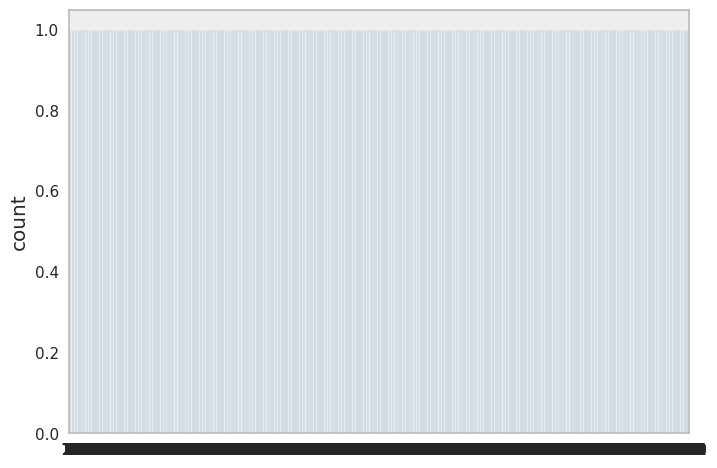

In [127]:

# Fitting K means Algorithm with 4 clusters
km = KMeans(n_clusters = 4,init='k-means++',random_state=10,n_init=1,max_iter=100)
label = km.fit_predict(X_std)
centroids = km.cluster_centers_
cluster = km.labels_

# visualising at the value count of points in each of the above-formed clusters:
frame = pd.DataFrame(X_std)
frame['Customer cluster'] = cluster
frame['Customer cluster'].value_counts()
plt.style.use('bmh')
sns.countplot(frame["Customer cluster"]);

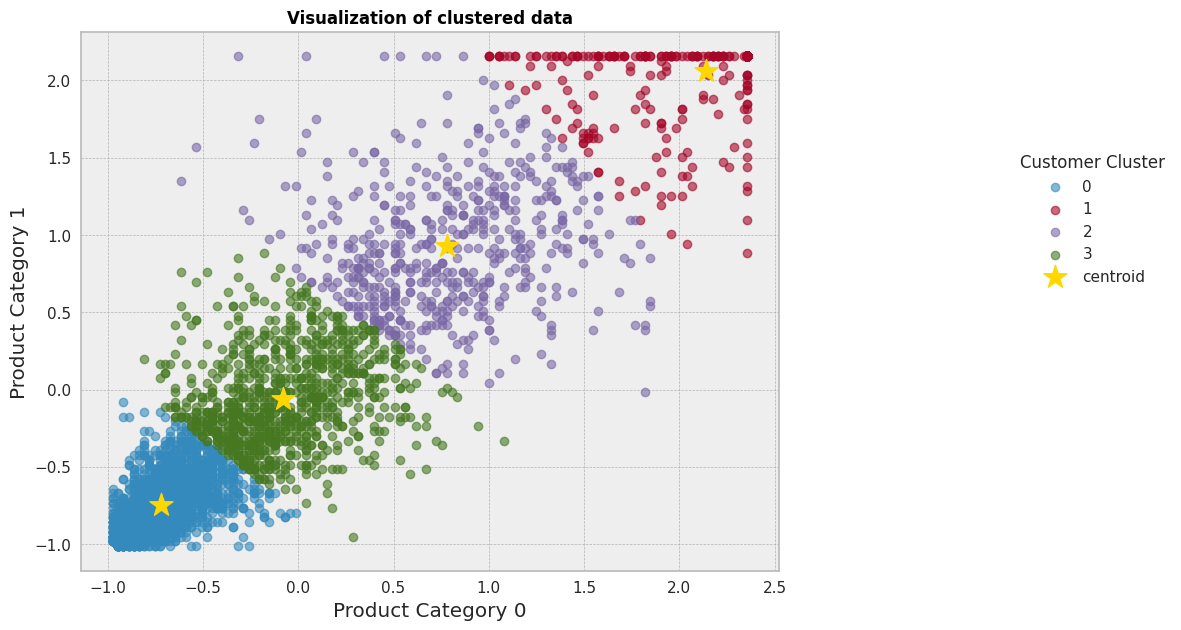

In [128]:
# Vizualization of Customers clusters

labels = np.unique(label)
plt.style.use('bmh')
plt.figure(figsize=(15, 7))
ax = plt.subplot(111)
sns.set_theme(style="whitegrid")
for i in labels:
    plt.scatter(X_std[label == i,0] , X_std[label == i,1] , label = i,alpha=0.6)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 300, marker='*',c='gold', label='centroid')
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
ax.legend(title='Customer Cluster',loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
plt.xlabel('Product Category 0')
plt.ylabel('Product Category 1')
plt.title('Visualization of clustered data',color='black',fontweight='bold')
plt.show()

In [129]:
#Analysing Product category wise sales in each Customer cluster
# Reseting index
# df = df.reset_index(drop=True)
# Creating DataFrame for cluster labels
f1 = pd.DataFrame(cluster)
# joining Dataframe
f2= df5.join(f1)
f2.rename(columns={0:'Customer_Category'},inplace=True)
# Merging Dataframe
df_news = pd.merge(df_new, f2, how='left', on='CustomerID')
print(df_news.shape)
df_news.head()


(356131, 14)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Description_processed,Product_Category,Product_Category_0,Product_Category_1,Customer_Category
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,hang heart t-light holder,0,193,116,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,metal lantern,0,193,116,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,cream cupid heart coat hanger,1,193,116,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,knit union flag hot water bottle,1,193,116,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,woolly hottie heart .,0,193,116,1


In [130]:
# Creating dataframe to understand product category wise sales in each customer cluster
df_product_sales = pd.pivot_table(df_news,values='Sales',index=['Product_Category'],columns=['Customer_Category'],aggfunc='sum')
df_product_sales

Customer_Category,0,1,2,3
Product_Category,,,,
0,271098.826,1047261.865,435148.145,396497.630
1,265403.255,1063926.165,468296.500,397809.075


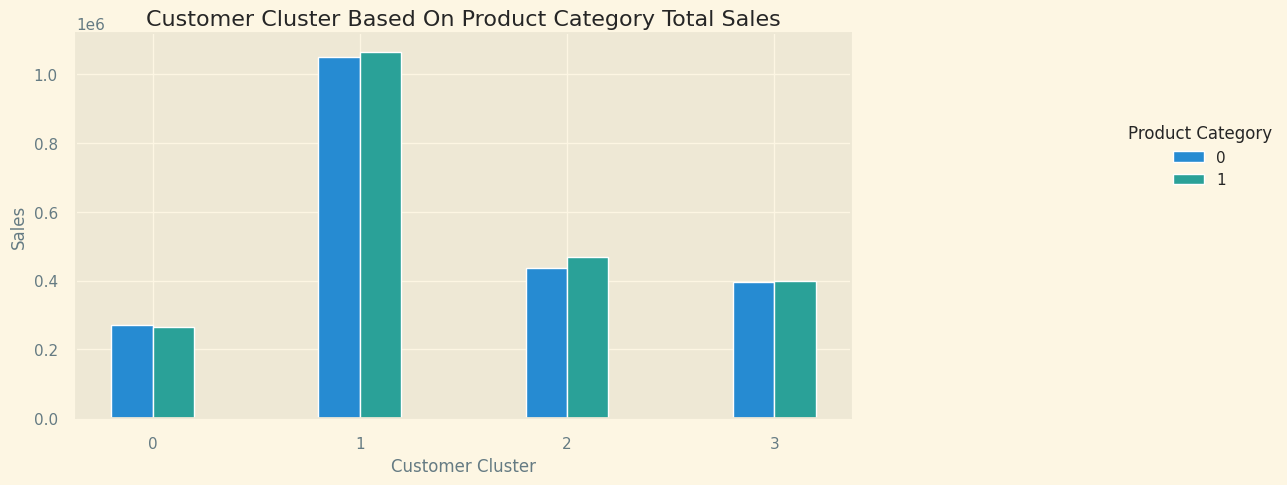

In [132]:

# Visualizing product category wise sales in each customer cluster
plt.style.use('Solarize_Light2')
x = np.arange(len(df_product_sales.columns))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 5))

# Loop through rows and plot each product category for each customer cluster
for i in range(len(df_product_sales)):
    ax.bar(x + (i * width), df_product_sales.iloc[i], width=width, label=str(df_product_sales.index[i]))

# Set x-tick positions and labels
ax.set_xticks(x + ((len(df_product_sales) / 2 - 0.5) * width))
ax.set_xticklabels(df_product_sales.columns)

plt.title('Customer Cluster Based On Product Category Total Sales')
ax.set_xlabel('Customer Cluster')
ax.set_ylabel('Sales')

# Adjust the legend
plt.legend(title='Product Category', loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)

plt.show()